# Regression Problem, Base Model Experiment

1. Models: xgbregressor
2. metrics: RMSE, MAE, MAPE, RMSLE

In [31]:
import pandas as pd
from src.func_data_diagnosis import *
from src.func_data_engineering import *
from src.func_model_tracker import *
from src.func_modelling import *
import matplotlib.pyplot as plt
from xgboost import XGBRegressor,plot_importance,plot_tree,to_graphviz
import joblib
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload
%cd C:\Users\tyler\repos\airbnb-forecast

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\tyler\repos\airbnb-forecast


## 1. Read features
Set up a connection

In [2]:
engine = connect_my_db("secrets/db_string")

Read the tables from PostgreSQL

In [3]:
df_list = read_table(engine, "FS_LIST_MONTHLY")
df_cal = read_table(engine, "FS_CAL_MONTHLY")
df_host = read_table(engine, "FS_HOST_MONTHLY")
df_rev = read_table(engine, "FS_REVIEW_MONTHLY")
df_booked = read_table(engine, "FS_BOOKED_MONTHLY")
df_loc = read_table(engine, "FS_LOCATION_MONTHLY")
df_time = read_table(engine, "FS_TIME_MONTHLY")
df_price = read_table(engine, "FS_PRICE_MONTHLY")

# Merge the features together to become main dataset
df_data = df_list.merge(df_cal, on = ['ID','YEAR_MONTH']).\
    merge(df_host, on = ['ID','YEAR_MONTH']).\
    merge(df_rev, on = ['ID','YEAR_MONTH']).\
    merge(df_booked, on = ['ID','YEAR_MONTH']).\
    merge(df_loc, on = ['ID','YEAR_MONTH']).\
    merge(df_time, on = ['ID','YEAR_MONTH']).\
    merge(df_price, on = ['ID','YEAR_MONTH'])

# 2. Train, valifdation, test data split

In [12]:
# for app
# new host input = [
#     # list
#      'PROPERTY_TYPE', 'ROOM_TYPE', 'ACCOMMODATES'
#     , 'BATHROOMS', 'BEDROOMS', 'BEDS', 'BED_TYPE', 'SQUARE_FEET'
#     , 'GUESTS_INCLUDED'
#     # cal
#     # host
#     # review
#     # booked
#     # loation
#     , 'NEIGHBOURHOOD'
#     # , 'LATITUDE', 'LONGITUDE'
#     # time
#     # price
#     , 'TXN_PRICE', 'SECURITY_DEPOSIT', 'CLEANING_FEE', 'EXTRA_PEOPLE'
# ]
#
# default/calcluate = [
#     # list
#     'YEAR_MONTH'
#     , 'INSTANT_BOOKABLE', 'CANCELLATION_POLICY'
#     , 'REQUIRE_GUEST_PROFILE_PICTURE', 'REQUIRE_GUEST_PHONE_VERIFICATION'
#     , 'LUXURY_FLAG'
#     # cal
#     , 'AVG_MINIMUM_NIGHTS', 'AVG_MAXIMUM_NIGHTS'
#     # host
#     , 'HOST_MONTHS', 'HOST_RESPONSE_RATE'
#     , 'HOST_ACCEPTANCE_RATE', 'HOST_IS_SUPERHOST', 'HOST_LISTINGS_COUNT'
#     , 'HOST_HAS_PROFILE_PIC', 'HOST_IDENTITY_VERIFIED'
#     # review
#     , 'NUMBER_OF_REVIEWS', 'MONTH_SINCE_FIRST_REVIEW'
#     , 'MONTH_SINCE_LAST_REVIEW', 'REVIEW_SCORES_RATING', 'REVIEW_SCORES_ACCURACY'
#     , 'REVIEW_SCORES_CLEANLINESS', 'REVIEW_SCORES_CHECKIN'
#     , 'REVIEW_SCORES_COMMUNICATION', 'REVIEW_SCORES_LOCATION'
#     , 'REVIEW_SCORES_VALUE', 'REVIEWS_PER_MONTH'
#     # booked
#     , 'BOOKED', 'BOOKED_LAG_1', 'BOOKED_LAG_3', 'BOOKED_LAG1_MINUS_LAG3'
#     , 'BOOKED_LAG1_MA3',  'BOOKED_LAG1_MINUS_LAG1MA3'
#     # loation
#     , 'IS_LOCATION_EXACT'
#     # , 'LATITUDE', 'LONGITUDE'
#     # time
#     , 'MONTH', 'QUARTER', 'YEAR', 'YEAR_START', 'YEAR_END'
#     # price
#     , 'PRICE_PER_GUEST'
#     , 'PRICE_LAG_1', 'PRICE_LAG_2', 'PRICE_LAG_3', 'PRICE_MINUS_LAG_1'
#     , 'PRICE_MINUS_LAG_2', 'PRICE_MINUS_LAG_3', 'PRICE_MA_3', 'PRICE_MINUS_MA_3'
# ]

# for base model
# todo: handle None value: 'HOST_RESPONSE_TIME',
# todo: clean HOST_NEIGHBOURHOOD
# todo: add 'HOST_ENTIRE_HOMES','HOST_PRIVATE_ROOMS', 'HOST_SHARED_ROOMS'
# 'CITY', 'STATE','ZIPCODE'
#  in local models
# todo: cluster listings against street/suburb, CALENDAR_UPDATED
# todo: clean and experiment: 'HOST_VERIFICATIONS','AMENITIES','SMART_LOCATION'
# todo: add active flag based on CALENDAR_UPDATED

col_selected = [
    # list
    'ID', 'YEAR_MONTH', 'PROPERTY_TYPE', 'ROOM_TYPE', 'ACCOMMODATES'
    , 'BATHROOMS', 'BEDROOMS', 'BEDS', 'BED_TYPE', 'SQUARE_FEET'
    , 'INSTANT_BOOKABLE', 'GUESTS_INCLUDED', 'CANCELLATION_POLICY'
    , 'REQUIRE_GUEST_PROFILE_PICTURE', 'REQUIRE_GUEST_PHONE_VERIFICATION'
    , 'LUXURY_FLAG'
    # cal
    , 'AVG_MINIMUM_NIGHTS', 'AVG_MAXIMUM_NIGHTS'
    # leakage , 'AVAILABILITY_60', 'AVAILABILITY_90', 'AVAILABILITY_365'
    # host
    , 'HOST_MONTHS', 'HOST_RESPONSE_RATE'
    , 'HOST_ACCEPTANCE_RATE', 'HOST_IS_SUPERHOST', 'HOST_LISTINGS_COUNT'
    , 'HOST_HAS_PROFILE_PIC', 'HOST_IDENTITY_VERIFIED'
    # review
    , 'NUMBER_OF_REVIEWS', 'MONTH_SINCE_FIRST_REVIEW'
    , 'MONTH_SINCE_LAST_REVIEW', 'REVIEW_SCORES_RATING', 'REVIEW_SCORES_ACCURACY'
    , 'REVIEW_SCORES_CLEANLINESS', 'REVIEW_SCORES_CHECKIN'
    , 'REVIEW_SCORES_COMMUNICATION', 'REVIEW_SCORES_LOCATION'
    , 'REVIEW_SCORES_VALUE', 'REVIEWS_PER_MONTH'
    # booked
    , 'BOOKED', 'BOOKED_LAG_1', 'BOOKED_LAG_3', 'BOOKED_LAG1_MINUS_LAG3'
    , 'BOOKED_LAG1_MA3',  'BOOKED_LAG1_MINUS_LAG1MA3'
    # loation
    , 'NEIGHBOURHOOD', 'IS_LOCATION_EXACT'
    # , 'LATITUDE', 'LONGITUDE'
    # time
    , 'MONTH', 'QUARTER', 'YEAR', 'YEAR_START', 'YEAR_END'
    # price
    , 'TXN_PRICE', 'PRICE_PER_GUEST', 'SECURITY_DEPOSIT', 'CLEANING_FEE', 'EXTRA_PEOPLE'
    , 'PRICE_LAG_1', 'PRICE_LAG_2', 'PRICE_LAG_3', 'PRICE_MINUS_LAG_1'
    , 'PRICE_MINUS_LAG_2', 'PRICE_MINUS_LAG_3', 'PRICE_MA_3', 'PRICE_MINUS_MA_3'
]

# cols_num = ['ACCOMMODATES','BATHROOMS','BEDROOMS','BEDS','INSTANT_BOOKABLE'
#     ,'IS_BUSINESS_TRAVEL_READY','GUESTS_INCLUDED','REQUIRE_GUEST_PROFILE_PICTURE'
#     ,'REQUIRE_GUEST_PHONE_VERIFICATION','LUXURY_FLAG','LATITUDE','LONGITUDE'
#     ,'IS_LOCATION_EXACT','ADJUSTED_PRICE','HOST_RESPONSE_RATE'
#     ,'HOST_ACCEPTANCE_RATE','HOST_IS_SUPERHOST','HOST_LISTINGS_COUNT','HOST_HAS_PROFILE_PIC'
#     ,'HOST_IDENTITY_VERIFIED','YEAR','MONTH','HOST_MONTHS','NUMBER_OF_REVIEWS'
#     ,'REVIEW_SCORES_RATING', 'REVIEWS_PER_MONTH']

cols_cate = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
    ,'NEIGHBOURHOOD']

df_base = df_data[col_selected]
df_base.shape

(148835, 62)

In [13]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148835 entries, 0 to 148834
Data columns (total 62 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   ID                                148835 non-null  int64  
 1   YEAR_MONTH                        148835 non-null  object 
 2   PROPERTY_TYPE                     148835 non-null  object 
 3   ROOM_TYPE                         148835 non-null  object 
 4   ACCOMMODATES                      148835 non-null  int64  
 5   BATHROOMS                         148718 non-null  float64
 6   BEDROOMS                          148606 non-null  float64
 7   BEDS                              147612 non-null  float64
 8   BED_TYPE                          148835 non-null  object 
 9   SQUARE_FEET                       1044 non-null    float64
 10  INSTANT_BOOKABLE                  148835 non-null  int64  
 11  GUESTS_INCLUDED                   148835 non-null  i

In [14]:
# use Jun data as test, May as val
df_train, df_val, df_test, y_train, y_val, y_test, df_test_pred = split_data(df_base,'2020-06', '2020-05')
print(df_train.shape, df_val.shape, df_test.shape,
      y_train.shape, y_val.shape, y_test.shape,
      df_test_pred.shape)

(101526, 61) (23862, 61) (23447, 61) (101526,) (23862,) (23447,) (23447, 3)


# 3. Feature engineering

In [15]:
cols_drop = ['ID','YEAR_MONTH']
for df in [df_train, df_val, df_test]:
    df.drop(cols_drop, axis = 1, inplace = True)

In [16]:
# one hot encode
df_train_ohe, df_val_ohe, df_test_ohe = encode_data(cols_cate, df_train, df_test, df_val)
print(df_train_ohe.shape, df_val_ohe.shape, df_test_ohe.shape)

(101526, 105) (23862, 105) (23447, 105)


# 4. Model Experiment

In [ ]:
# for baseline, gobal model
# with custom metrics to avoid negative pred/nan rsmle

model2 = XGBRegressor(n_estimators=1000,learning_rate = .01,random_state = 29)
print(model2)
model2.fit(df_train_ohe, y_train
           , eval_metric = rmsle
          , eval_set = [(df_train_ohe, y_train), (df_val_ohe, y_val)]
          , early_stopping_rounds = 20
          , verbose = True)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

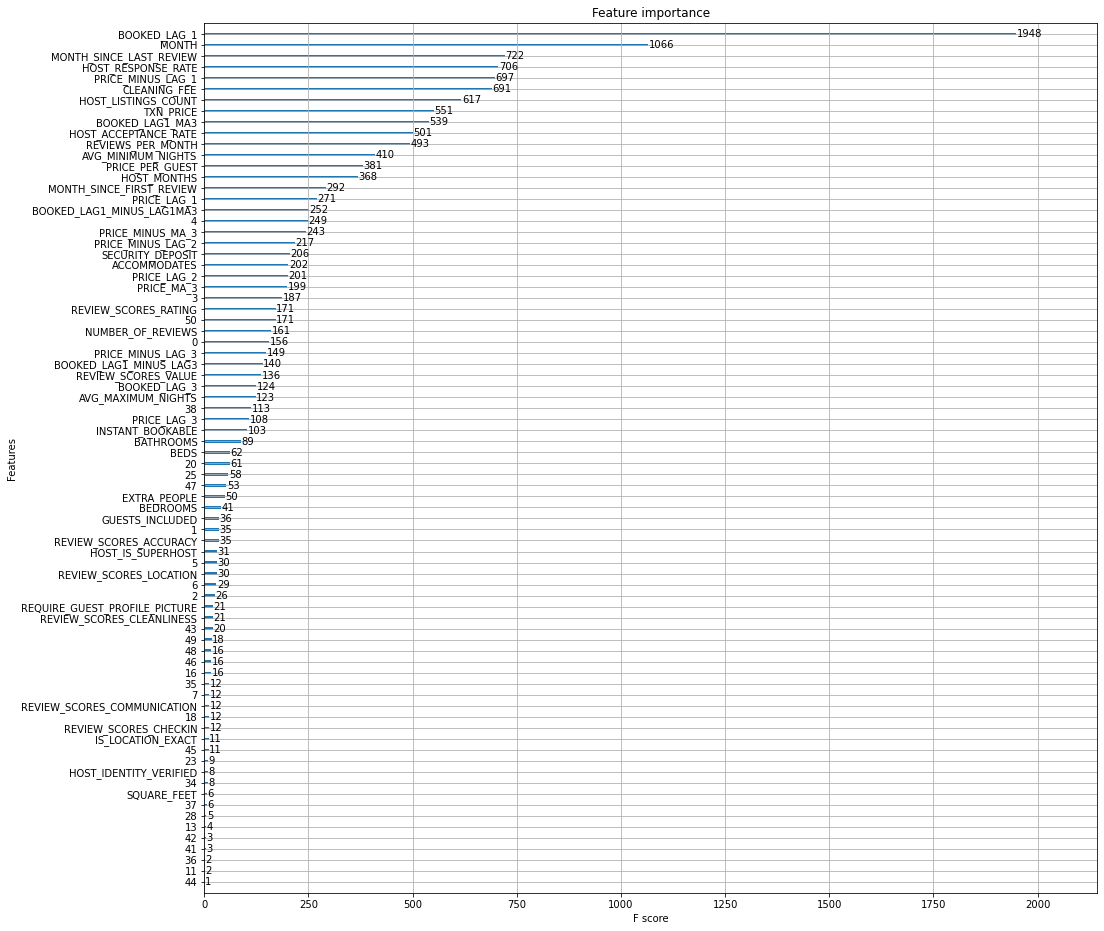

In [18]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_importance(model2,ax=ax)

In [21]:
# # viz trees
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Users/tyler/Anaconda3/Lib/site-packages/graphviz/'
#
# plot_tree(model2,ax=ax)
# to_graphviz(model2,ax=ax)

ExecutableNotFound: failed to execute ['dot', '-Tsvg'], make sure the Graphviz executables are on your systems' PATH

# 5. Train the Final Model

In [ ]:
# train the model
# create y
y_final = df_base.BOOKED
# create X
X_final = df_base.drop(['ID','YEAR_MONTH','BOOKED'], axis=1)

cols_cate_final = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
    ,'NEIGHBOURHOOD']
X_final, encoder = encode_data(cols_cate_final, X_final, out_encoder=True)

In [34]:
# save the encoder for model api
joblib.dump(encoder, "model/ohe_base.ohe")

['model/ohe_base.ohe']

In [35]:
# train the model
model_base = XGBRegressor(n_estimators=1000,learning_rate = .01,random_state = 29)
tic = time.time()
model_base.fit(X_final, y_final)
toc = time.time()
train_time = round(toc - tic,2)

In [39]:
# save the model for model api
joblib.dump(model_base, "model/model_base.model")

['model/model_base.model']

In [36]:
print(model_base)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=29,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)


In [38]:
train_time

1246.49

# Appendix

In [ ]:
# create and save ohe transformer object for model api
# cols_cate = ['PROPERTY_TYPE','ROOM_TYPE','BED_TYPE','CANCELLATION_POLICY'
#     ,'NEIGHBOURHOOD_CLEANSED']
# ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

# df_ohe_train = pd.DataFrame(ohe.fit_transform(df_train[cols_cate]))
#
# joblib.dump(ohe, "model/ohe_base.ohe")
#
# ohe1  = joblib.load("model/ohe_base.ohe")
# df_ohe1 = pd.DataFrame(ohe1.transform(df_test[cols_cate]))
# df_ohe = pd.DataFrame(ohe.transform(df_test[cols_cate]))
#
# # compare
# df_ohe1.equals(df_ohe)

In [18]:
# test model api

df_testapi = df_base.head()


,ID,PROPERTY_TYPE,ROOM_TYPE,ACCOMMODATES,BATHROOMS,BEDROOMS,BEDS,BED_TYPE,INSTANT_BOOKABLE,GUESTS_INCLUDED,CANCELLATION_POLICY,REQUIRE_GUEST_PROFILE_PICTURE,REQUIRE_GUEST_PHONE_VERIFICATION,LUXURY_FLAG,NEIGHBOURHOOD_CLEANSED,LATITUDE,LONGITUDE,IS_LOCATION_EXACT,YEAR_MONTH,ADJUSTED_PRICE,BOOKED,HOST_RESPONSE_RATE,HOST_ACCEPTANCE_RATE,HOST_IS_SUPERHOST,HOST_LISTINGS_COUNT,HOST_ENTIRE_HOMES,HOST_PRIVATE_ROOMS,HOST_SHARED_ROOMS,HOST_HAS_PROFILE_PIC,HOST_IDENTITY_VERIFIED,NUMBER_OF_REVIEWS,REVIEW_SCORES_RATING,REVIEWS_PER_MONTH,YEAR,MONTH
0,9835,house,private room,2,1.0,1.0,2.0,real bed,0,1,strict_14_with_grace_period,0,0,0,Manningham,-37.77268,145.09213,0,2020-01,60.0,0,0.0,NaN,0.0,1,0,1,0,0.0,0.0,4,90.0,0.04,2020,1
1,10803,apartment,private room,2,1.0,1.0,2.0,futon,1,1,strict_14_with_grace_period,1,1,0,Moreland,-37.76651,144.98074,1,2020-01,40.0,25,100.0,NaN,1.0,1,0,1,0,1.0,1.0,141,89.0,1.66,2020,1
2,12936,apartment,entire home/apt,2,1.0,1.0,1.0,real bed,0,2,strict_14_with_grace_period,0,0,0,Port Phillip,-37.85976,144.97737,1,2020-01,101.0,12,100.0,NaN,0.0,10,10,0,0,1.0,1.0,40,93.0,0.35,2020,1
3,16760,house,private room,2,1.0,1.0,1.0,real bed,0,1,moderate,0,0,0,Port Phillip,-37.86453,144.99224,1,2020-01,62.0,14,100.0,NaN,0.0,1,0,1,0,1.0,1.0,84,91.0,0.85,2020,1
4,38271,apartment,entire home/apt,5,1.0,3.0,3.0,real bed,0,1,flexible,0,0,0,Casey,-38.05725,145.33936,1,2020-01,99.0,9,100.0,NaN,1.0,1,1,0,0,1.0,1.0,137,96.0,1.23,2020,1
